# Project 2  

## Multi layer classification using Neural network

### Importing necessary libraries

In [ ]:
# Read Fashion MNIST dataset
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import util_mnist_reader as mnist_reader
from pylab import rcParams
import string
import matplotlib.pyplot as plt
import math
from matplotlib import rc
from sklearn.model_selection import train_test_split
from collections import Counter, defaultdict
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import struct
from scipy.special import expit
from sklearn.manifold import TSNE
from ast import literal_eval

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)


# Your code goes here . . .

## Reading Image data

In [ ]:

X_train, y_train = mnist_reader.load_mnist('data/fashion', kind='train')
X_test, y_test = mnist_reader.load_mnist('data/fashion', kind='t10k')


## Exploring the image dataset

In [6]:
print("X_train: ", X_train.shape, " type: ", type(X_train))
print("X_test: ", X_test.shape, " type: ", type(X_test))
print("y_train: ", y_train.shape, " type: ", type(y_train))
print("y_test: ", y_test.shape, " type: ", type(y_test))

X_train:  (60000, 784)  type:  <class 'numpy.ndarray'>
X_test:  (10000, 784)  type:  <class 'numpy.ndarray'>
y_train:  (60000,)  type:  <class 'numpy.ndarray'>
y_test:  (10000,)  type:  <class 'numpy.ndarray'>


In [7]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [8]:
train_images = X_train.reshape(60000,28,28)

In [9]:
test_images = X_test.reshape(10000, 28, 28)

In [10]:
test_images.shape

(10000, 28, 28)

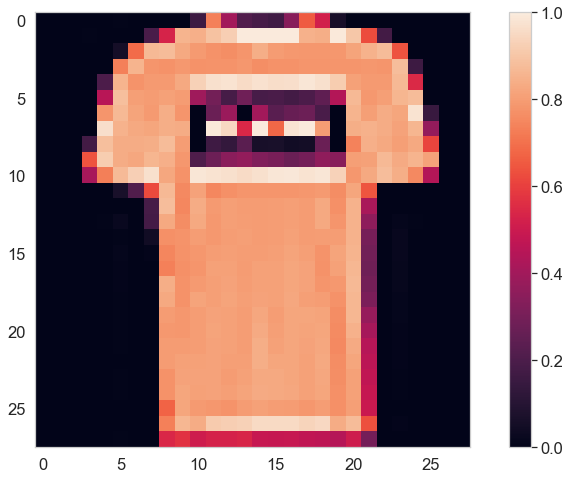

In [122]:
plt.figure()
plt.imshow(train_images[1])
plt.colorbar()
plt.grid(False)
plt.show()

In [12]:
train_images = train_images / 255.0

test_images = test_images / 255.0

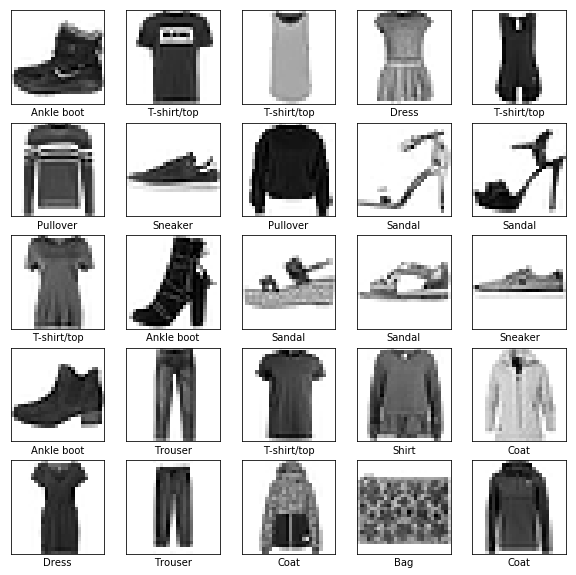

In [13]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])
plt.show()

# Part 1

# Neural Network Image Classifier from scratch in Python


## Model Implementation

In [53]:
def read_fashion_mnist(images_path, labels_path):
    labels = y_train
    images = X_train.reshape(len(labels), 784)

    return images, labels

def mle(y, axis=1):
    return np.argmax(y, axis)


def one_hot(y, n_labels):
    mat = np.zeros((len(y), n_labels))
    for i, val in enumerate(y):
        mat[i, val] = 1
    return mat


def L2_reg(lambda_, w1, w2):
    return (lambda_ / 2.0) * (np.sum(w1 ** 2) + np.sum(w2 ** 2))


def L1_reg(lambda_, w1, w2):
    return (lambda_ / 2.0) * (np.abs(w1).sum() + np.abs(w2).sum())


def cross_entropy(outputs, y_target):
    return -np.sum(np.log(outputs) * y_target, axis=1)


def plot_product(X, y, idx):
    img = X[idx].reshape(28,28)
    plt.imshow(img, cmap=plt.cm.binary)
    plt.title('true label: %s' % class_names[y[idx]])
    plt.colorbar()
    plt.grid(False)
    plt.show()

def plot_error(model):
    plt.plot(range(len(model.error_)), model.error_)
    plt.ylabel('Error')
    plt.xlabel('Epochs')
    plt.show()
    
    
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img.reshape(28,28), cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
 
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')
  
def plot_image_grid(X_test, y_test, y_hat, num_rows=5, num_cols=3):
  num_images = num_rows*num_cols
  plt.figure(figsize=(2*2*num_cols, 2*num_rows))
  for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, y_hat, y_test, X_test)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, y_hat,  y_test)

In [54]:
X, y = read_fashion_mnist(X_train, y_train)
N_FEATURES = 28 * 28 # 28x28 pixels for the images
N_CLASSES = 10

In [58]:
def sigmoid(z):
    return expit(z)

def sigmoid_prime(z):
    sg = sigmoid(z)
    return sg * (1 - sg)

In [63]:
def softmax(z):
    return (np.exp(z.T) / np.sum(np.exp(z), axis=1)).T

In [116]:
class NNClassifier:

    def __init__(self, n_classes, n_features, n_hidden_units=30,
                 l1=0.0, l2=0.0, epochs=500, learning_rate=0.01,
                 n_batches=1, random_seed=None):

        if random_seed:
            np.random.seed(random_seed)
        self.n_classes = n_classes
        self.n_features = n_features
        self.n_hidden_units = n_hidden_units
        self.w1, self.w2 = self._init_weights()
        self.l1 = l1
        self.l2 = l2
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.n_batches = n_batches

############## Initializing weights to random values ########        
    def _init_weights(self):
        w1 = np.random.uniform(-1.0, 1.0,
                               size=(self.n_hidden_units, self.n_features))        
        w2 = np.random.uniform(-1.0, 1.0,
                               size=(self.n_classes, self.n_hidden_units))
        return w1, w2

############# feedforward  #############

    # Phase 1
      
    def _forward(self, X):
        net_input = X.copy()
        net_hidden = self.w1.dot(net_input.T)
        act_hidden = sigmoid(net_hidden)

    # Phase 2x

        net_out = self.w2.dot(act_hidden)
        act_out = sigmoid(net_out)
        return net_input, net_hidden, act_hidden, net_out, act_out

    
########## Back Propagation #############
# Back-propagation is an optimization problem where we have to find the function minima for our cost function.

    def _backward(self, net_input, net_hidden, act_hidden, act_out, y):

        ########## Phase 1 #############

        sigma3 = act_out - y
        sigma2 = self.w2.T.dot(sigma3) * sigmoid_prime(net_hidden)
        
        ########## Phases 2 #############

        grad1 = sigma2.dot(net_input)
        grad2 = sigma3.dot(act_hidden.T)
        return grad1, grad2      

    def _error(self, y, output):
        L1_term = L1_reg(self.l1, self.w1, self.w2)
        L2_term = L2_reg(self.l2, self.w1, self.w2)
        error = cross_entropy(output, y) + L1_term + L2_term
        return 0.5 * np.mean(error)

############## Update Weights ############## 
# To find new bias values for the hidden layer, the values returned by Equation can be simply 
# multiplied with the learning rate and subtracted from the current hidden layer bias values 
    
    def _backprop_step(self, X, y):
        net_input, net_hidden, act_hidden, net_out, act_out = self._forward(X)
        y = y.T

        grad1, grad2 = self._backward(net_input, net_hidden, act_hidden, act_out, y)

        # regularize
        grad1 += (self.w1 * (self.l1 + self.l2))
        grad2 += (self.w2 * (self.l1 + self.l2))

        error = self._error(y, act_out)
        
        return error, grad1, grad2

###### Prediction of class #######
    def predict(self, X):
        Xt = X.copy()
        net_input, net_hidden, act_hidden, net_out, act_out = self._forward(Xt)
        return mle(net_out.T)

    def predict_proba(self, X):
        Xt = X.copy()
        net_input, net_hidden, act_hidden, net_out, act_out = self._forward(Xt)
        return softmax(act_out.T)

###### Training of model #######    

    def fit(self, X, y):
        self.error_ = []
        X_data, y_data = X.copy(), y.copy()
        y_data_enc = one_hot(y_data, self.n_classes)
                
        X_mbs = np.array_split(X_data, self.n_batches)
        y_mbs = np.array_split(y_data_enc, self.n_batches)
        
        j=0
        for i in range(self.epochs):
            
            epoch_errors = []

            for Xi, yi in zip(X_mbs, y_mbs):
                
                # update weights
                error, grad1, grad2 = self._backprop_step(Xi, yi)
                epoch_errors.append(error)
                self.w1 -= (self.learning_rate * grad1)
                self.w2 -= (self.learning_rate * grad2)
            self.error_.append(np.mean(epoch_errors))
            
            
            if self.epochs % 2 == 0:
                print(j, ' Loss function value: ', np.mean(epoch_errors))
                j+=2
              
        return self
    
####### Calculating the accuracy score manually ########    
    def score(self, X, y):
        y_hat = self.predict(X)
        return np.sum(y == y_hat, axis=0) / float(X.shape[0])

## Training

In [139]:
nn = NNClassifier(
    n_classes=N_CLASSES, 
    n_features=N_FEATURES,
    n_hidden_units=128,
    l2=0.5,
    l1=0.0,
    epochs=300,
    learning_rate=0.0001,
    n_batches=25,
    random_seed=RANDOM_SEED
).fit(X_train, y_train);

0  Loss function value:  4474.83962427537
2  Loss function value:  4362.74386403275
4  Loss function value:  4332.080918163309
6  Loss function value:  4309.443871237006
8  Loss function value:  4291.65850326209
10  Loss function value:  4277.161273856171
12  Loss function value:  4262.169471237677
14  Loss function value:  4248.825532341081
16  Loss function value:  4236.196200773299
18  Loss function value:  4223.539608082438
20  Loss function value:  4212.046760831312
22  Loss function value:  4200.121812797099
24  Loss function value:  4188.235042055319
26  Loss function value:  4176.857711238259
28  Loss function value:  4165.656752456655
30  Loss function value:  4154.204169918612
32  Loss function value:  4142.9826808155285
34  Loss function value:  4132.03821409673
36  Loss function value:  4121.1207654394
38  Loss function value:  4109.883491859448
40  Loss function value:  4099.494026265327
42  Loss function value:  4089.282582995552
44  Loss function value:  4079.27898421150

364  Loss function value:  2765.6741587401075
366  Loss function value:  2759.1303003758467
368  Loss function value:  2752.5110998549153
370  Loss function value:  2746.2834494767685
372  Loss function value:  2740.4923657116715
374  Loss function value:  2733.816578694841
376  Loss function value:  2727.5383227840125
378  Loss function value:  2720.1613993842316
380  Loss function value:  2713.7381038604717
382  Loss function value:  2707.34789388778
384  Loss function value:  2701.0043436024857
386  Loss function value:  2695.338866323143
388  Loss function value:  2688.813749742444
390  Loss function value:  2681.9977208648534
392  Loss function value:  2674.458940427535
394  Loss function value:  2668.3537600364316
396  Loss function value:  2661.642137326396
398  Loss function value:  2655.689636755486
400  Loss function value:  2649.6939860307193
402  Loss function value:  2643.3212539434876
404  Loss function value:  2637.208157897744
406  Loss function value:  2631.47038642587

KeyboardInterrupt: 

## Training loss vs epoch

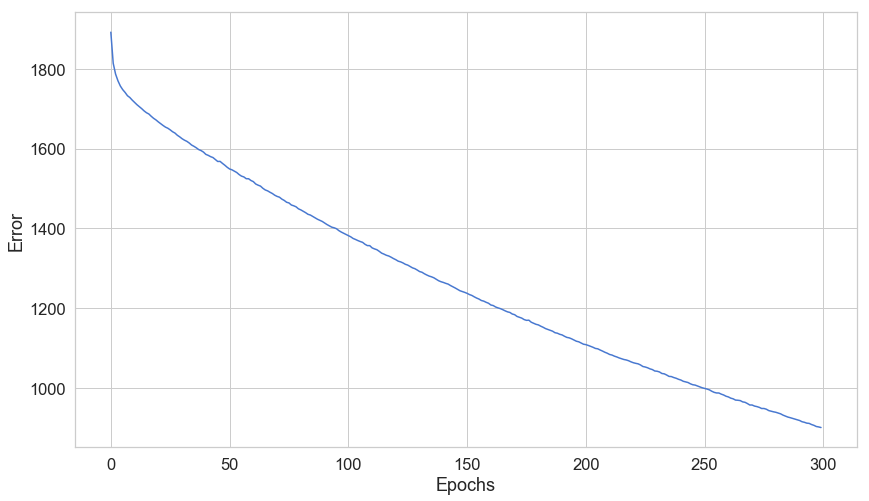

In [126]:
plot_error(nn)

In [127]:
# y_hat = nn.predict_proba(X_test)
y_hat1 = mle(nn.predict_proba(X_test))

In [128]:
y_test.shape

(10000,)

In [129]:
y_hat1.shape

(10000,)

In [130]:
nn_val = NNClassifier(
    n_classes=N_CLASSES, 
    n_features=N_FEATURES,
    n_hidden_units=50,
    l2=0.5,
    l1=0.0,
    epochs=300,
    learning_rate=0.001,
    n_batches=25,
    random_seed=RANDOM_SEED
).fit(X_test, y_test);

0  Loss function value:  1673.4922932767095
2  Loss function value:  1624.7354989426888
4  Loss function value:  1583.1582461998146
6  Loss function value:  1544.2808400739614
8  Loss function value:  1507.3335931280315
10  Loss function value:  1472.463421214987
12  Loss function value:  1438.1033207380895
14  Loss function value:  1404.036685897789
16  Loss function value:  1371.6858668741563
18  Loss function value:  1339.2425031189732
20  Loss function value:  1308.890785646372
22  Loss function value:  1279.6313776826905
24  Loss function value:  1249.910968225614
26  Loss function value:  1222.5293282588434
28  Loss function value:  1194.574904565714
30  Loss function value:  1168.3519302170819
32  Loss function value:  1142.5588484623179
34  Loss function value:  1116.5535941093954
36  Loss function value:  1093.40966832837
38  Loss function value:  1068.1903325788726
40  Loss function value:  1043.338810659735
42  Loss function value:  1019.8421588381083
44  Loss function value

364  Loss function value:  114.91209361913553
366  Loss function value:  112.99510136248699
368  Loss function value:  115.20502112143863
370  Loss function value:  113.88761306727041
372  Loss function value:  112.26720487573638
374  Loss function value:  111.50449825297689
376  Loss function value:  111.02912038321107
378  Loss function value:  111.56272032502406
380  Loss function value:  110.37514077514145
382  Loss function value:  108.19195984413733
384  Loss function value:  109.64898309851928
386  Loss function value:  110.84441596573461
388  Loss function value:  111.1962668008922
390  Loss function value:  110.44504871138687
392  Loss function value:  111.31961831111266
394  Loss function value:  111.61911872574412
396  Loss function value:  109.5959276463771
398  Loss function value:  108.0375284835894
400  Loss function value:  108.2598377884887
402  Loss function value:  108.63612243632866
404  Loss function value:  108.68409695515267
406  Loss function value:  107.5166422

## Validation loss vs epoch

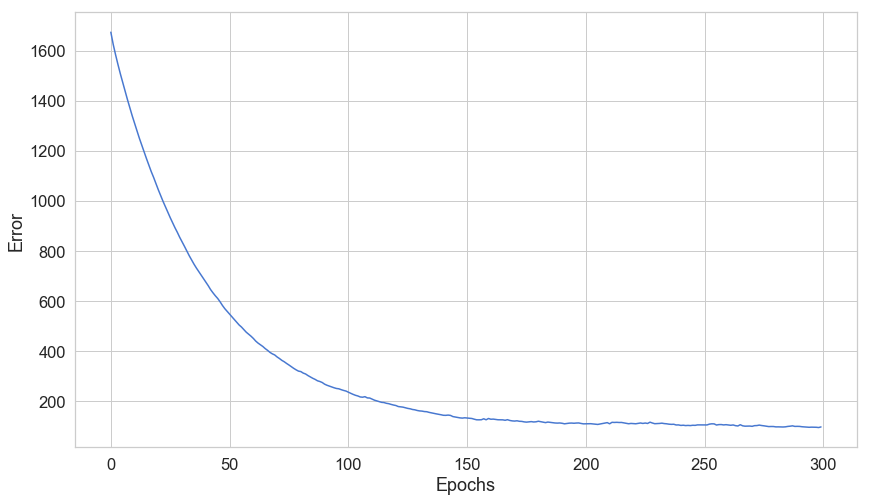

In [132]:
plot_error(nn_val)

In [133]:
print('Train Accuracy: %.2f%%' % (nn.score(X_train, y_train) * 100))
print('Test Accuracy: %.2f%%' % (nn.score(X_test, y_test) * 100))

Train Accuracy: 83.65%
Test Accuracy: 82.07%


In [98]:
nn.predict_proba(X_test[1:2])

array([[0.08595448, 0.08596088, 0.20958891, 0.08598276, 0.08611728,
        0.08595256, 0.10253053, 0.08595281, 0.08599264, 0.08596714]])

In [99]:
y_hat = nn.predict_proba(X_test)


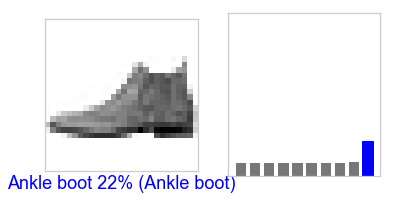

In [100]:
i = 0
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plot_image(i, y_hat, y_test, X_test)
plt.subplot(1, 2, 2)
plot_value_array(i, y_hat,  y_test)

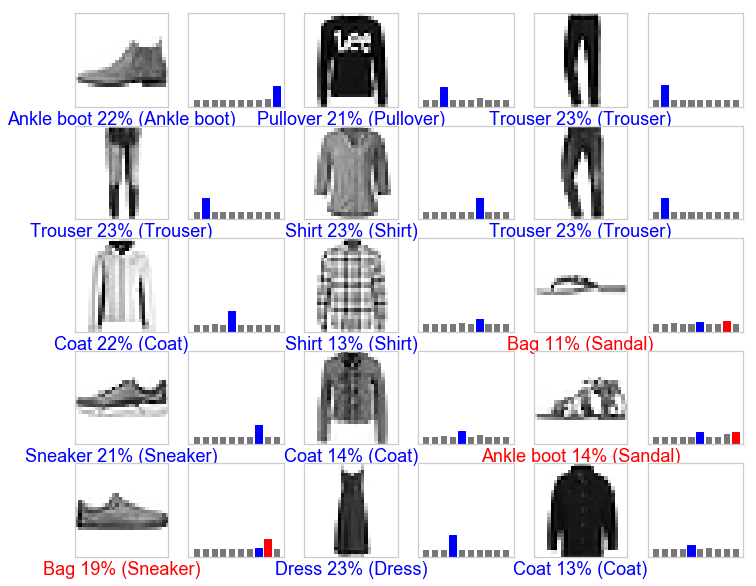

In [101]:
plot_image_grid(X_test, y_test, y_hat)

In [102]:
mle(nn.predict_proba(X_test[:5]))

array([9, 2, 1, 1, 6], dtype=int64)

In [103]:
nn.predict(X_test[:5])

array([9, 2, 1, 1, 6], dtype=int64)

## Extra preprocessing using sklearn for better accuracy

In [138]:
from sklearn.preprocessing import scale

X_train_scaled = scale(X_train.astype(np.float64))
X_test_scaled = scale(X_test.astype(np.float64))

nn = NNClassifier(
    n_classes=N_CLASSES, 
    n_features=N_FEATURES,
    n_hidden_units=64,
    l2=0.5,
    l1=0.0,
    epochs=300,
    learning_rate=0.01,
    n_batches=25,
    random_seed=RANDOM_SEED
).fit(X_train_scaled, y_train);

0  Loss function value:  10516.217079667633
2  Loss function value:  5567.363377083229
4  Loss function value:  4709.39196613378
6  Loss function value:  4045.918862939586
8  Loss function value:  3319.3780448789867
10  Loss function value:  3018.755348011006
12  Loss function value:  2748.339001222556
14  Loss function value:  2825.371007877628
16  Loss function value:  2409.920385390445
18  Loss function value:  2176.4687393738245
20  Loss function value:  3266.5173280557356
22  Loss function value:  2567.114071971437
24  Loss function value:  2619.3409667479195
26  Loss function value:  2741.8959094395627
28  Loss function value:  2365.8232488615176
30  Loss function value:  2117.6685369776255
32  Loss function value:  1877.1681937118199
34  Loss function value:  2889.296455624817
36  Loss function value:  5313.905083530799
38  Loss function value:  3361.888926291345
40  Loss function value:  3999.4364796570762
42  Loss function value:  3287.5794754420135
44  Loss function value:  2

364  Loss function value:  2928.0344501240456
366  Loss function value:  3156.3268405878684
368  Loss function value:  2721.174072339782
370  Loss function value:  2244.3064205479786
372  Loss function value:  2460.3939497539523
374  Loss function value:  2225.9876386367337
376  Loss function value:  2969.3355097540566
378  Loss function value:  2231.1309689464683
380  Loss function value:  2244.5659180121993
382  Loss function value:  2285.300191146553
384  Loss function value:  3598.0922038671956
386  Loss function value:  3079.45372697823
388  Loss function value:  2455.8415425410954
390  Loss function value:  2632.6483731687185
392  Loss function value:  2513.838213943195
394  Loss function value:  2898.1859213965245
396  Loss function value:  3131.0800484461797
398  Loss function value:  2867.351103973087
400  Loss function value:  3267.1543310472257
402  Loss function value:  3073.3432509090344
404  Loss function value:  2592.7092707707134
406  Loss function value:  2084.30522451

In [ ]:
plot_error(nn)

In [137]:
print('Train Accuracy: %.2f%%' % (nn.score(X_train_scaled, y_train) * 100))
print('Test Accuracy: %.2f%%' % (nn.score(X_test_scaled, y_test) * 100))

Train Accuracy: 87.66%
Test Accuracy: 84.62%


In [ ]:
y_hat = nn.predict_proba(X_test_scaled)

In [ ]:
plot_image_grid(X_test, y_test, y_hat)

# Part 2

In [140]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

2.0.0


In [157]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

In [158]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [159]:
history=model.fit(train_images, y_train, epochs=10)

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 3s 56us/sample - loss: 0.5147 - accuracy: 0.8205
Epoch 2/10
60000/60000 [==============================] - 3s 55us/sample - loss: 0.3902 - accuracy: 0.8613
Epoch 3/10
60000/60000 [==============================] - 3s 53us/sample - loss: 0.3548 - accuracy: 0.8723
Epoch 4/10
60000/60000 [==============================] - 3s 51us/sample - loss: 0.3292 - accuracy: 0.8805
Epoch 5/10
60000/60000 [==============================] - 3s 52us/sample - loss: 0.3113 - accuracy: 0.8866
Epoch 6/10
60000/60000 [==============================] - 3s 55us/sample - loss: 0.2980 - accuracy: 0.8902
Epoch 7/10
60000/60000 [==============================] - 3s 53us/sample - loss: 0.2875 - accuracy: 0.8932
Epoch 8/10
60000/60000 [==============================] - 4s 71us/sample - loss: 0.2769 - accuracy: 0.8969
Epoch 9/10
60000/60000 [==============================] - 4s 60us/sample - loss: 0.2678 - accuracy: 0.9007
Epoch 10/10
60

In [160]:
history.history


{'loss': [0.5147192056775093,
  0.39017614591121674,
  0.35481879883209866,
  0.329197598473231,
  0.3112707947631677,
  0.29795114510258036,
  0.2874974981546402,
  0.27690661325653393,
  0.2677521632750829,
  0.2608210048039754],
 'accuracy': [0.82051665,
  0.8612667,
  0.87226665,
  0.88046664,
  0.8865833,
  0.89015,
  0.89323336,
  0.8969333,
  0.90066665,
  0.90245]}

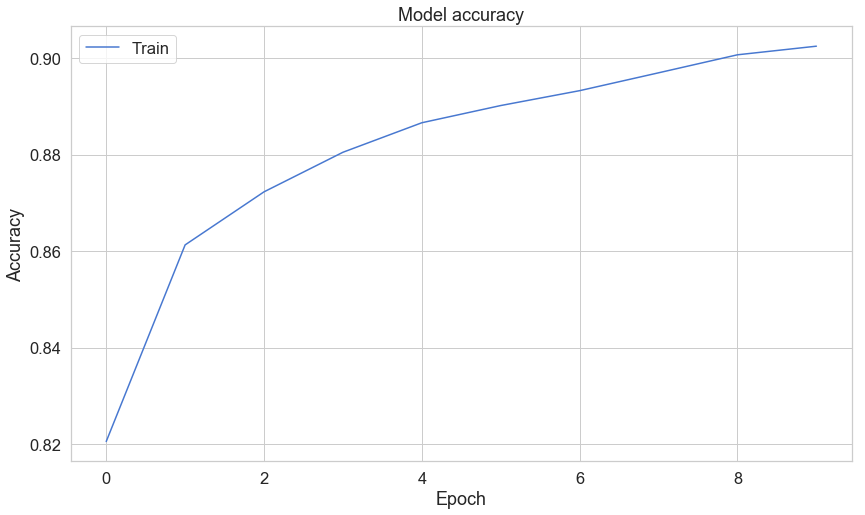

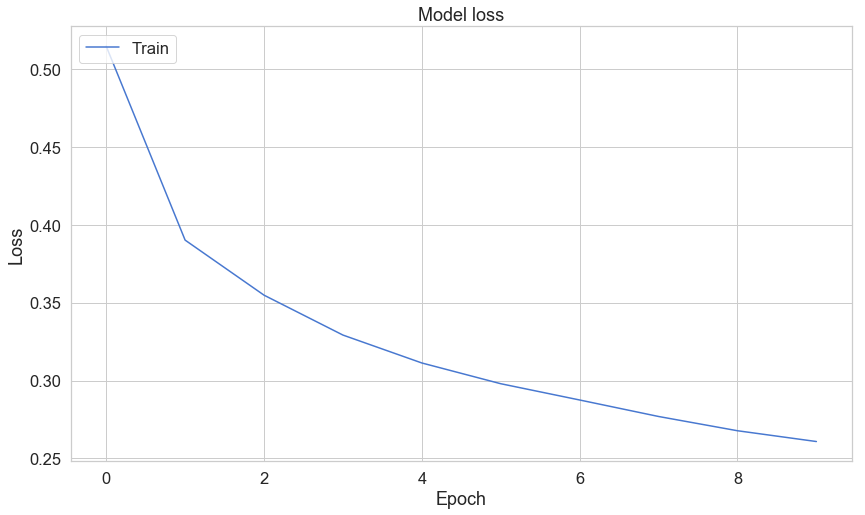

In [161]:

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [162]:
test_loss, test_acc = model.evaluate(test_images,  y_test, verbose=2)

print('\nTest accuracy:', test_acc)

10000/1 - 0s - loss: 0.2323 - accuracy: 0.8667

Test accuracy: 0.8667


In [150]:
predictions = model.predict(test_images)

In [151]:
type(predictions)

numpy.ndarray

In [152]:
y_pred = []
for i in range(len(predictions)):
    y_pred.append(np.argmax(predictions[i]))

In [153]:
np.asarray(y_pred)

array([9, 2, 1, ..., 8, 1, 5], dtype=int64)

In [154]:
y_pred[2]

1

In [155]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 


In [156]:
results = confusion_matrix(y_pred, y_test)  #(true, pred)
print ('Confusion Matrix :')
print(results) 
print ('Accuracy Score :',accuracy_score(y_pred, y_test))
print ('Report : ')
print (classification_report(y_pred, y_test))

Confusion Matrix :
[[846   1  14  19   1   0 137   0   4   0]
 [  1 971   1   6   0   0   0   0   0   0]
 [ 20   1 813  12  99   0  81   0   1   0]
 [ 34  18  11 912  32   1  43   0   4   0]
 [  3   5  84  31 809   0  73   0   8   0]
 [  1   0   0   0   0 956   0  10   2   7]
 [ 88   2  75  17  59   0 657   0   3   1]
 [  0   0   0   0   0  22   0 952   3  22]
 [  7   2   2   3   0   0   9   0 975   0]
 [  0   0   0   0   0  21   0  38   0 970]]
Accuracy Score : 0.8861
Report : 
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      1022
           1       0.97      0.99      0.98       979
           2       0.81      0.79      0.80      1027
           3       0.91      0.86      0.89      1055
           4       0.81      0.80      0.80      1013
           5       0.96      0.98      0.97       976
           6       0.66      0.73      0.69       902
           7       0.95      0.95      0.95       999
           8       0.97      

In [18]:
predictions[0]

array([3.1114009e-08, 1.8559934e-08, 1.8145863e-09, 3.8446625e-08,
       5.9904309e-08, 5.9096189e-04, 1.4779526e-08, 3.5144389e-02,
       1.9145217e-08, 9.6426445e-01], dtype=float32)

In [19]:
np.argmax(predictions[0])

9

In [21]:
y_test[0]

9

In [54]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

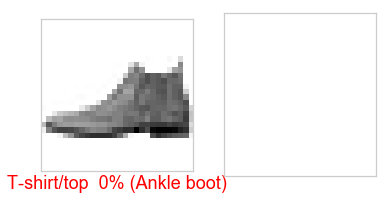

In [94]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], y_test, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  y_test)
plt.show()

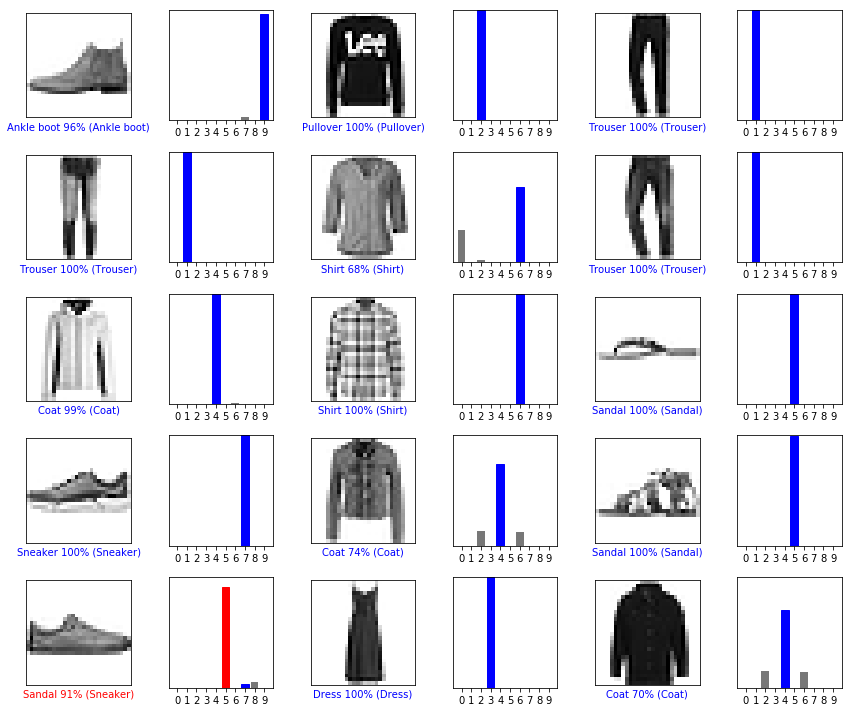

In [30]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], y_test, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], y_test)
plt.tight_layout()
plt.show()

In [31]:
# Grab an image from the test dataset.
img = test_images[1]

print(img.shape)

(28, 28)


In [32]:
# Add the image to a batch where it's the only member.
img = (np.expand_dims(img,0))

print(img.shape)

(1, 28, 28)


In [33]:
predictions_single = model.predict(img)

print(predictions_single)

[[1.6963269e-05 1.3889264e-11 9.9866545e-01 1.9919478e-12 4.6654555e-04
  7.8881826e-09 8.5106137e-04 5.6349885e-13 4.9967985e-10 2.4384393e-13]]


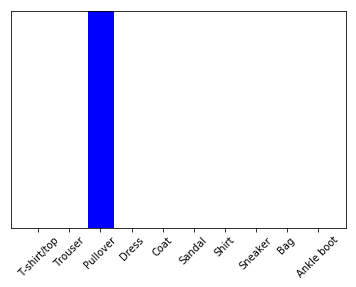

In [35]:
plot_value_array(1, predictions_single[0], y_test)
_ = plt.xticks(range(10), class_names, rotation=45)

In [36]:
np.argmax(predictions_single[0])

2

# Part 3

In [238]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
from keras.utils import to_categorical

In [239]:

X_train, y_train = mnist_reader.load_mnist('data/fashion', kind='train')
X_test, y_test = mnist_reader.load_mnist('data/fashion', kind='t10k')


In [240]:
#one-hot encode target column
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_train[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

In [241]:
#create model
model = Sequential()
#add model layers
model.add(Conv2D(128, kernel_size=3, activation='relu', input_shape=(28,28,1)))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))

In [242]:
#compile model using accuracy to measure model performance
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [243]:
#reshape data to fit model
X_train = X_train.reshape(60000,28,28,1)
X_test = X_test.reshape(10000,28,28,1)

In [244]:

#train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3)

Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 208s 3ms/step - loss: 0.5009 - accuracy: 0.8324 - val_loss: 0.3869 - val_accuracy: 0.8634
Epoch 2/3
60000/60000 [==============================] - 202s 3ms/step - loss: 0.3261 - accuracy: 0.8824 - val_loss: 0.3599 - val_accuracy: 0.8730
Epoch 3/3
60000/60000 [==============================] - 204s 3ms/step - loss: 0.2735 - accuracy: 0.8999 - val_loss: 0.3509 - val_accuracy: 0.8783


In [245]:
y_pred = model.predict(X_test)

In [246]:
y_pred = []
for i in range(len(predictions)):
    y_pred.append(np.argmax(predictions[i]))


In [247]:
y_pred= np.asarray(y_pred)

In [248]:
type(y_pred)


numpy.ndarray

In [249]:
X_test, y_test = mnist_reader.load_mnist('data/fashion', kind='t10k')


In [250]:
y_pred

array([9, 2, 1, ..., 8, 1, 5], dtype=int64)

In [251]:
y_test

array([9, 2, 1, ..., 8, 1, 5], dtype=uint8)

In [252]:
results = confusion_matrix(y_pred, y_test)  #(true, pred)
print ('Confusion Matrix :')
print(results) 
print ('Accuracy Score :',accuracy_score(y_pred, y_test))
print ('Report : ')
print (classification_report(y_pred, y_test))


Confusion Matrix :
[[846   1  14  19   1   0 137   0   4   0]
 [  1 971   1   6   0   0   0   0   0   0]
 [ 20   1 813  12  99   0  81   0   1   0]
 [ 34  18  11 912  32   1  43   0   4   0]
 [  3   5  84  31 809   0  73   0   8   0]
 [  1   0   0   0   0 956   0  10   2   7]
 [ 88   2  75  17  59   0 657   0   3   1]
 [  0   0   0   0   0  22   0 952   3  22]
 [  7   2   2   3   0   0   9   0 975   0]
 [  0   0   0   0   0  21   0  38   0 970]]
Accuracy Score : 0.8861
Report : 
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      1022
           1       0.97      0.99      0.98       979
           2       0.81      0.79      0.80      1027
           3       0.91      0.86      0.89      1055
           4       0.81      0.80      0.80      1013
           5       0.96      0.98      0.97       976
           6       0.66      0.73      0.69       902
           7       0.95      0.95      0.95       999
           8       0.97      

In [253]:
history.history

{'val_loss': [0.38692748498916624, 0.3599476675271988, 0.3508881942510605],
 'val_accuracy': [0.8633999824523926, 0.8730000257492065, 0.8783000111579895],
 'loss': [0.5009203440229097, 0.32608284804920357, 0.27352900820374487],
 'accuracy': [0.83243334, 0.88238335, 0.89985]}

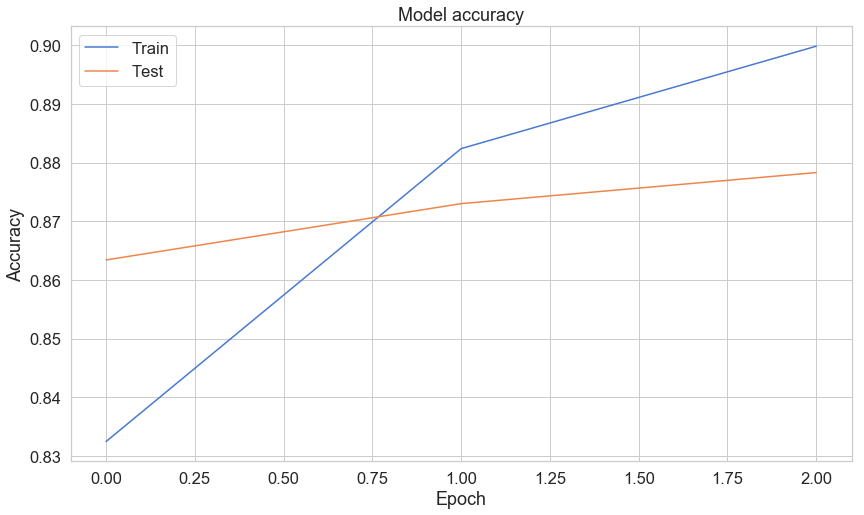

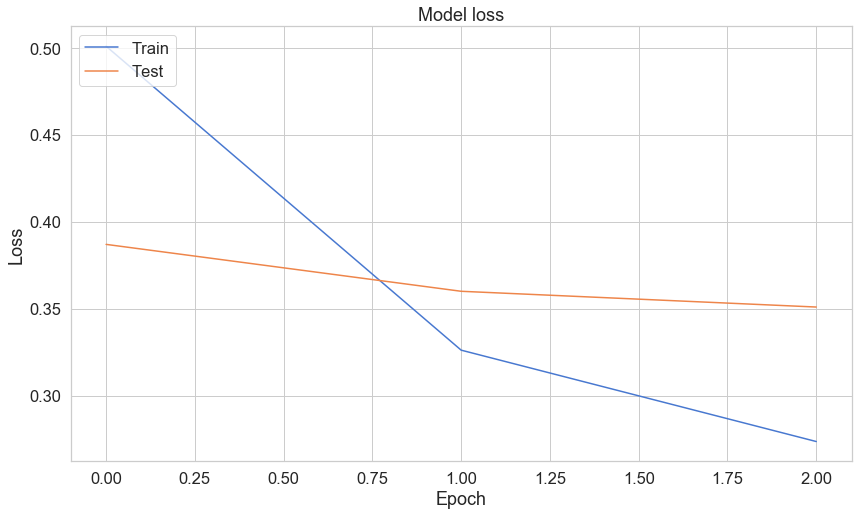

In [254]:

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [194]:
y_pred

array([[1.04498679e-06, 1.45712020e-09, 9.40870581e-09, ...,
        1.72138261e-03, 1.00354606e-04, 9.84355509e-01],
       [1.70068106e-05, 1.08781627e-07, 9.94105339e-01, ...,
        3.56038658e-12, 1.08364029e-09, 3.12714787e-09],
       [1.55236330e-06, 9.99970794e-01, 1.20400941e-07, ...,
        1.02246789e-09, 9.62835202e-07, 7.02355063e-09],
       ...,
       [1.83905449e-05, 1.21961641e-09, 6.93754773e-05, ...,
        1.80354565e-09, 9.99896288e-01, 9.40945366e-09],
       [1.18780300e-12, 1.00000000e+00, 1.80523149e-11, ...,
        3.54040061e-12, 3.47542134e-12, 7.27946523e-12],
       [2.89497571e-03, 5.04560303e-05, 1.02064441e-04, ...,
        3.48561071e-03, 5.25400275e-03, 7.54667493e-03]], dtype=float32)

In [12]:
#predict first 4 images in the test set
model.predict(X_test[:4])

array([[1.40690432e-07, 5.06699752e-11, 1.31276656e-09, 3.40475226e-09,
        1.23016186e-09, 1.76266383e-03, 2.07774242e-08, 1.79803523e-04,
        7.89099097e-09, 9.98057306e-01],
       [1.33310765e-04, 1.93195797e-06, 9.91508603e-01, 1.83036154e-05,
        6.59458013e-03, 1.02183695e-09, 1.74329849e-03, 1.91695604e-10,
        1.06590980e-09, 5.70138992e-10],
       [6.04652178e-06, 9.99944806e-01, 2.19027470e-06, 1.16801457e-05,
        2.45449132e-06, 2.32669981e-06, 2.63332640e-05, 8.57091393e-08,
        3.88446779e-06, 1.40191743e-08],
       [2.82585679e-05, 9.99921441e-01, 1.04934361e-06, 4.35376387e-05,
        3.12705993e-06, 1.43355706e-07, 2.42916826e-06, 1.08285665e-08,
        1.37787339e-07, 1.86829112e-08]], dtype=float32)

In [13]:
#actual results for first 4 images in test set
y_test[:4]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)